# OpenSmile vs wav2vec

In [13]:
# !pip3 install opensmile
# !pip3 install audb
# !pip3 install audmetric
# !pip3 install audplot
# !pip3 install audonnx
# !pip3 install audinterface

import opensmile
import audeer
import audmetric
import audplot
import audinterface
import audonnx

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

## Загрузка данных - The Berlin Database of Emotional Speech (Emo-DB)

In [4]:
model_root = 'model'
cache_root = 'cache'

audeer.mkdir(cache_root)
def cache_path(file):
    return os.path.join(cache_root, file)

In [5]:
import audb
import audformat


db = audb.load(
    'emodb',
    version='1.1.1',
    format='wav',
    mixdown=True,
    sampling_rate=16000,
    full_path=False,    
    cache_root=cache_root,
    verbose=True,
)
speaker = db['files']['speaker'].get()
emotion = db['emotion']['emotion'].get()

audformat.utils.concat([emotion, speaker])

Get:   emodb v1.1.1
Cache: /cephfs/home/chepel/cache/emodb/1.1.1/fe182b91


,emotion,speaker
file,,
wav/03a01Fa.wav,happiness,3
wav/03a01Nc.wav,neutral,3
wav/03a01Wa.wav,anger,3
wav/03a02Fc.wav,happiness,3
wav/03a02Nc.wav,neutral,3
...,...,...
wav/16b10Lb.wav,boredom,16
wav/16b10Tb.wav,sadness,16
wav/16b10Td.wav,sadness,16


In [32]:
labels = sorted(list(set(db['emotion']['emotion'].get())))
label_dict = {}
for i in range(len(labels)):
    label_dict[labels[i]] = i

## OpenSMILE

In [6]:
smile = opensmile.Smile(
    opensmile.FeatureSet.ComParE_2016,
    opensmile.FeatureLevel.Functionals,
    sampling_rate=16000,    
    resample=True,    
    num_workers=5,
    verbose=True,
)

path = cache_path('smile.pkl')
if not os.path.exists(path):
    features = smile.process_index(
        emotion.index,
        root=db.root,
    )
    features.to_pickle(path)    
    
features_smile = pd.read_pickle(path)
features_smile

,,,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
file,start,end,,,,,,,,,,,,,,,,,,,,,
wav/03a01Fa.wav,0 days,0 days 00:00:01.898250,2.935072,0.203297,0.010989,0.295957,0.521095,1.027880,0.225138,0.506785,0.731923,0.036379,...,4.534245,0.369439,2.608829,2.575876,19.005924,0.681891,117.093933,56.662125,120.517212,53.837585
wav/03a01Nc.wav,0 days,0 days 00:00:01.611250,3.087914,0.155844,0.889610,0.230797,0.747830,1.160158,0.517033,0.412327,0.929361,0.039586,...,5.695178,0.373871,3.123539,3.173356,-18.526028,0.684225,126.975647,63.870255,157.944702,60.625206
wav/03a01Wa.wav,0 days,0 days 00:00:01.877812500,3.673083,0.677778,0.011111,0.379012,0.901301,1.801537,0.522289,0.900236,1.422525,0.027108,...,8.072537,0.486622,3.802572,3.807790,-19.999348,0.385978,177.820740,89.425529,153.756653,92.122215
wav/03a02Fc.wav,0 days,0 days 00:00:02.006250,3.149658,0.549223,0.720207,0.252871,0.691515,1.456156,0.438644,0.764641,1.203285,0.044348,...,8.049533,0.537332,3.237765,3.310604,-17.577114,0.442254,161.931686,82.129478,134.208984,73.309341
wav/03a02Nc.wav,0 days,0 days 00:00:01.439812500,2.437313,0.632353,0.691176,0.386229,0.809192,1.433426,0.422963,0.624234,1.047197,0.047513,...,6.743878,0.511177,2.217380,2.281038,-16.731733,0.492748,106.720039,57.315079,97.520103,41.168545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wav/16b10Lb.wav,0 days,0 days 00:00:03.442687500,3.308008,0.100890,0.014837,0.450570,0.805156,1.323949,0.354586,0.518794,0.873379,0.059215,...,8.917046,0.681655,2.385576,2.390011,-19.996981,0.537082,118.114395,65.305817,102.050064,44.002724
wav/16b10Tb.wav,0 days,0 days 00:00:03.500625,2.817487,0.104956,0.472303,0.298808,0.898184,1.372837,0.599376,0.474654,1.074030,0.111207,...,8.454210,0.531393,3.011052,3.035630,-19.587982,0.486605,133.106750,83.190590,112.855782,72.329666
wav/16b10Td.wav,0 days,0 days 00:00:03.934187500,1.854920,0.119171,0.000000,0.208670,0.607462,1.031825,0.398792,0.424362,0.823154,0.102642,...,6.234570,0.470659,2.219766,2.233577,-19.786058,0.620368,110.055237,51.608723,83.898209,39.287560


In [7]:
# create classifier and grouping object
clf = make_pipeline(
    StandardScaler(), 
    SVC(gamma='auto'),
)
logo = LeaveOneGroupOut()

def experiment(
    features,
    targets,
    groups,
):        
    truths = []
    preds = []
    
    # leave-one-speaker loop    
    pbar = audeer.progress_bar(
        total=len(groups.unique()),
        desc='Run experiment',
    )
    for train_index, test_index in logo.split(
        features, 
        targets, 
        groups=groups,
    ):
        train_x = features.iloc[train_index]
        train_y = targets[train_index]
        clf.fit(train_x, train_y)
        
        truth_x = features.iloc[test_index]
        truth_y = targets[test_index]
        predict_y = clf.predict(truth_x)
        
        truths.append(truth_y)
        preds.append(predict_y)
        
        pbar.update()
        
    # combine speaker folds
    truth = pd.concat(truths)
    truth.name = 'truth'
    pred = pd.Series(
        np.concatenate(preds),
        index=truth.index,
        name='prediction',
    )
    
    return truth, pred

In [8]:
truth_smile, pred_smile = experiment(
    features_smile,
    emotion,
    speaker,
)

In [55]:
# Unweighted Average Recall (UAR)
"{:.3f}".format(audmetric.unweighted_average_recall(truth_smile, pred_smile))

'0.771'

## Wav2Vec

In [35]:
url = 'https://zenodo.org/record/6221127/files/w2v2-L-robust-12.6bc4a7fd-1.1.0.zip'
dst_path = cache_path('model.zip')

if not os.path.exists(dst_path):
    audeer.download_url(
        url, 
        dst_path, 
        verbose=True,
    )
    
if not os.path.exists(model_root):
    audeer.extract_archive(
        dst_path, 
        model_root, 
        verbose=True,
    )

In [38]:
model = audonnx.load(model_root)
model

Input:
  signal:
    shape: [1, -1]
    dtype: tensor(float)
    transform: None
Output:
  hidden_states:
    shape: [1, 1024]
    dtype: tensor(float)
    labels: [hidden_states-0, hidden_states-1, hidden_states-2, (...), hidden_states-1021,
      hidden_states-1022, hidden_states-1023]
  logits:
    shape: [1, 3]
    dtype: tensor(float)
    labels: [arousal, dominance, valence]

In [43]:
interface = audinterface.Feature(
    model.labels('logits'),
    process_func=model,
    process_func_args={
        'outputs': 'logits',
    },
    sampling_rate=16000,
    resample=True,    
    verbose=True,
)

In [44]:
hidden_states = audinterface.Feature(
    model.labels('hidden_states'),
    process_func=model,
    process_func_args={
        'outputs': 'hidden_states',
    },
    sampling_rate=16000,    
    resample=True,    
    num_workers=5,
    verbose=True,
)

path = cache_path('w2v2.pkl')
if not os.path.exists(path):
    features_w2v2 = hidden_states.process_index(
        emotion.index,
        root=db.root,
    )
    features_w2v2.to_pickle(path)    
    
features_w2v2 = pd.read_pickle(path)
features_w2v2

,,,hidden_states-0,hidden_states-1,hidden_states-2,hidden_states-3,hidden_states-4,hidden_states-5,hidden_states-6,hidden_states-7,hidden_states-8,hidden_states-9,...,hidden_states-1014,hidden_states-1015,hidden_states-1016,hidden_states-1017,hidden_states-1018,hidden_states-1019,hidden_states-1020,hidden_states-1021,hidden_states-1022,hidden_states-1023
file,start,end,,,,,,,,,,,,,,,,,,,,,
wav/03a01Fa.wav,0 days,0 days 00:00:01.898250,-0.007891,0.006736,-0.005898,-0.006566,-0.004559,-0.008148,0.168698,0.006812,0.113164,-0.001617,...,0.003587,0.011148,-0.050405,0.008359,0.034025,-0.064220,0.139168,0.007794,0.007637,0.006209
wav/03a01Nc.wav,0 days,0 days 00:00:01.611250,-0.007629,0.006001,-0.007628,-0.006588,-0.005104,-0.008472,0.199000,0.006391,0.071222,-0.001760,...,0.003145,0.011300,-0.018726,0.008156,0.015245,-0.056928,0.083291,0.007600,0.007721,0.005684
wav/03a01Wa.wav,0 days,0 days 00:00:01.877812500,-0.007874,0.006600,-0.008576,-0.007047,-0.004646,-0.008129,0.237001,0.007115,0.188141,-0.001287,...,0.003982,0.011190,-0.036640,0.008163,0.062221,-0.112500,0.302140,0.007813,0.007812,0.007133
wav/03a02Fc.wav,0 days,0 days 00:00:02.006250,-0.007407,0.006326,-0.010519,-0.005899,-0.004216,-0.007912,0.109786,0.006558,0.088926,-0.001507,...,0.003656,0.011320,-0.041450,0.008284,-0.010972,-0.139131,0.366497,0.007560,0.008487,0.004726
wav/03a02Nc.wav,0 days,0 days 00:00:01.439812500,-0.007313,0.006525,-0.010693,-0.004869,-0.004605,-0.008149,0.122609,0.006291,0.032912,-0.001508,...,0.003650,0.010983,-0.058476,0.008078,-0.008553,-0.000632,0.296581,0.007574,0.008161,0.005591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wav/16b10Lb.wav,0 days,0 days 00:00:03.442687500,-0.007212,0.006251,-0.006754,-0.006353,-0.004147,-0.007847,0.023312,0.007121,0.040396,-0.001996,...,0.003988,0.011588,-0.043439,0.008200,-0.027195,-0.063882,-0.051351,0.007314,0.007467,0.005633
wav/16b10Tb.wav,0 days,0 days 00:00:03.500625,-0.007274,0.006054,-0.006579,-0.006229,-0.004043,-0.005949,-0.005269,0.006985,-0.119985,-0.001811,...,0.003704,0.011652,-0.047649,0.008086,-0.013412,0.171493,-0.094538,0.007363,0.006186,0.005715
wav/16b10Td.wav,0 days,0 days 00:00:03.934187500,-0.007491,0.006536,-0.006867,-0.007232,-0.004012,-0.005708,-0.095532,0.006726,-0.191503,-0.002289,...,0.004344,0.011328,-0.064138,0.008109,-0.004146,0.111839,-0.037554,0.007447,0.006693,0.005184


In [45]:
truth_w2v2, pred_w2v2 = experiment(
    features_w2v2,
    emotion,
    speaker,
)

In [53]:
"{:.3f}".format(audmetric.unweighted_average_recall(truth_w2v2, pred_w2v2))

'0.934'

## Итоги

In [65]:
print('F-1 score для wav2vec = {:.2f}'.format(f1_score(truth_w2v2, pred_w2v2, average='weighted')))
print('F-1 score для smile = {:.2f}'.format(f1_score(truth_smile, pred_smile, average='weighted')))

F-1 score для wav2vec = 0.94
F-1 score для smile = 0.79


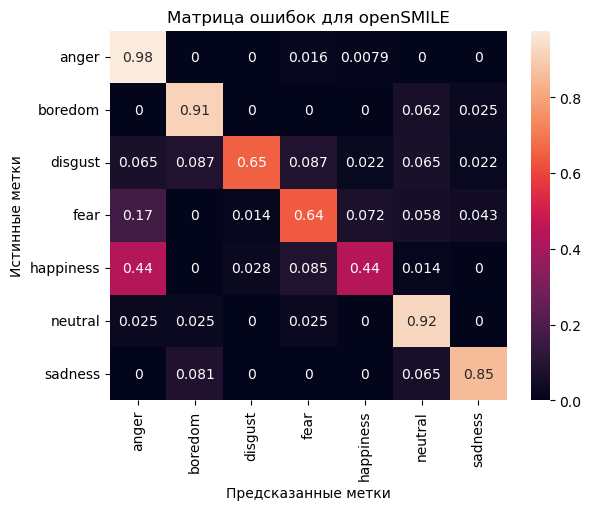

In [66]:
cm_1 = confusion_matrix(truth_smile, pred_smile, normalize='true')
sns.heatmap(cm_1, annot=True, xticklabels=sorted(labels), yticklabels=sorted(labels))
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.title(f'Матрица ошибок для openSMILE')
plt.show()

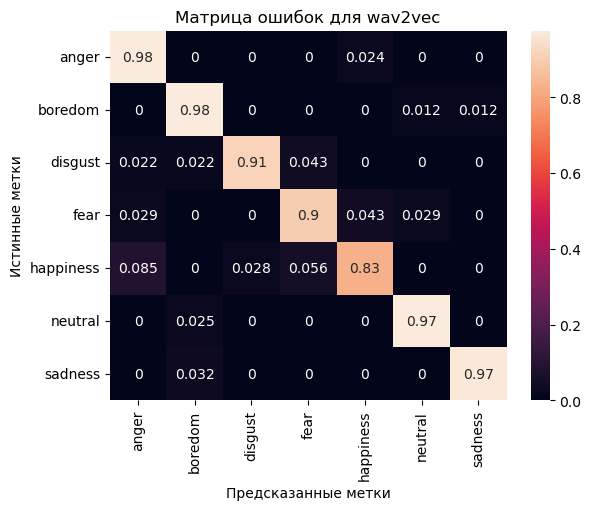

In [68]:
cm_2 = confusion_matrix(truth_w2v2, pred_w2v2, normalize='true')
sns.heatmap(cm_2, annot=True, xticklabels=sorted(labels), yticklabels=sorted(labels))
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.title(f'Матрица ошибок для wav2vec')
plt.show()